In [9]:
import time
import numpy as np
from tqdm import tqdm
import pandas as pd
import scipy as sp
from theano import tensor as tt
import pymc as pm
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jit
from functools import partial 
from jax.scipy.stats import norm
from jax.scipy.special import logsumexp

from src.load_data import load_traintest_sparseclass
from src import conformal_Bayes_functions as cb
from src import Bayes_MCMC_functions as bmcmc

import time
import numpy as np
from tqdm import tqdm
import pandas as pd
import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm
import jax.scipy as jsp
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


Inconsistency for test point 0:
  Split Method candidate set: {2, 3}
  Full Method candidate set:  {3}
Inconsistency for test point 1:
  Split Method candidate set: {1, 2, 3}
  Full Method candidate set:  {3}
Inconsistency for test point 5:
  Split Method candidate set: {2, 3}
  Full Method candidate set:  {2}
Inconsistency for test point 6:
  Split Method candidate set: {0, 2}
  Full Method candidate set:  {2}
Inconsistency for test point 8:
  Split Method candidate set: {0, 2, 3}
  Full Method candidate set:  set()


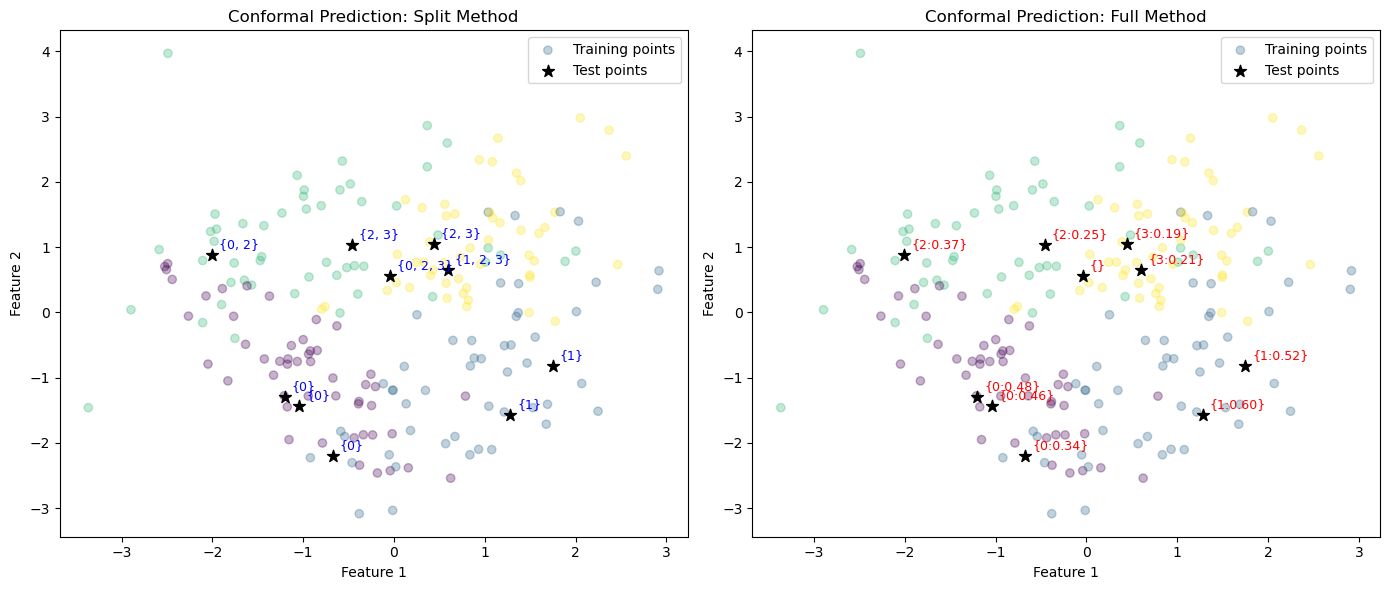

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.datasets import make_classification

# ------------------------------------------------------------------
# Split Method (Multiclass)
# ------------------------------------------------------------------
def conformal_split_multiclass(alpha, y, x, x_test, seed=100):
    n = np.shape(y)[0]
    n_train = int(n/2)  # use half for training + calibration
    ls = LogisticRegressionCV(
        penalty='l1', 
        solver='saga', 
        cv=5, 
        random_state=seed,
        max_iter=5000
    )
    ls.fit(x[:n_train], y[:n_train])
    
    # Calibration: compute negative log–probability score for true labels on calibration set.
    y_cal = y[n_train:]
    proba_cal = ls.predict_proba(x[n_train:])
    scores_cal = -np.log(np.clip(proba_cal[np.arange(len(y_cal)), y_cal], 1e-6, 1-1e-6))
    
    # Threshold (d) is the (1-alpha)-quantile of calibration scores.
    k = int(np.ceil((n/2 + 1) * (1 - alpha)))
    d = np.sort(scores_cal)[k - 1]
    
    # For each test point, compute scores for each candidate label using the same model.
    proba_test = ls.predict_proba(x_test)  # shape: (n_test, n_classes)
    scores_test = -np.log(np.clip(proba_test, 1e-6, 1-1e-6))
    # Candidate label is included if its score is below or equal to d.
    region_split = scores_test <= d
    return region_split, d, ls

# ------------------------------------------------------------------
# Full Method (Multiclass)
# ------------------------------------------------------------------
def conformal_full_multiclass(alpha, y, x, x_test, C=1.0, seed=100):
    n_train = np.shape(y)[0]
    n_test = np.shape(x_test)[0]
    
    candidate_labels = np.unique(y)
    n_classes = candidate_labels.size
    
    # Prepare matrix for p-values and region indicator.
    pvals = np.zeros((n_test, n_classes))
    region_full = np.zeros((n_test, n_classes), dtype=bool)
    
    for i in range(n_test):
        for k in candidate_labels:
            # Augment training data with current test point labeled as k.
            x_aug = np.concatenate((x, x_test[i].reshape(1, -1)), axis=0)
            y_aug = np.append(y, k)
            ls = LogisticRegression(
                penalty='l1', 
                solver='saga', 
                C=C, 
                random_state=seed,
                max_iter=5000
            )
            ls.fit(x_aug, y_aug)
            
            # Compute predicted probabilities on the augmented dataset.
            proba_aug = ls.predict_proba(x_aug)  # shape: (n_train+1, n_classes)
            # For candidate label k, define a nonconformity score.
            p_k = proba_aug[:, k]
            scores = np.zeros(x_aug.shape[0])
            for j in range(n_train):
                # For training examples: use -log(p[k]) if true label equals k; else -log(1-p[k])
                if y_aug[j] == k:
                    scores[j] = -np.log(np.clip(p_k[j], 1e-6, 1-1e-6))
                else:
                    scores[j] = -np.log(np.clip(1 - p_k[j], 1e-6, 1-1e-6))
            # Test point (last entry) score.
            score_test = -np.log(np.clip(p_k[-1], 1e-6, 1-1e-6))
            
            # Compute p-value: fraction of examples whose score is at least the test point's score.
            pval = np.sum(scores >= score_test) / (n_train + 1)
            pvals[i, k] = pval
            region_full[i, k] = pval > alpha
    
    return region_full, pvals

# ------------------------------------------------------------------
# Generate a multi-class dataset with 4 classes.
# ------------------------------------------------------------------
X, y = make_classification(
    n_samples=200,       # total samples
    n_features=2,        # 2 features for visualization
    n_informative=2,
    n_redundant=0,
    n_classes=4,         # four classes
    n_clusters_per_class=1,
    random_state=42
)

# Generate a test set with 30 samples.
X_test, _ = make_classification(
    n_samples=10,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=4,
    n_clusters_per_class=1,
    random_state=24
)

alpha = 0.1

# ------------------------------------------------------------------
# Apply the Split Method (Multiclass)
# ------------------------------------------------------------------
region_split, d_split, ls_split_model = conformal_split_multiclass(alpha, y, X, X_test)
# region_split: Boolean array (n_test, n_classes)

# ------------------------------------------------------------------
# Apply the Full Method (Multiclass)
# ------------------------------------------------------------------
region_full, pvals_full = conformal_full_multiclass(alpha, y, X, X_test, C=1.0)

# ------------------------------------------------------------------
# Check for inconsistencies between the two approaches.
# ------------------------------------------------------------------
inconsistencies = False
for i in range(X_test.shape[0]):
    # Candidate sets from both methods.
    candidates_split = set(np.where(region_split[i])[0])
    candidates_full = set(np.where(region_full[i])[0])
    if candidates_split != candidates_full:
        inconsistencies = True
        print(f"Inconsistency for test point {i}:")
        print(f"  Split Method candidate set: {candidates_split}")
        print(f"  Full Method candidate set:  {candidates_full}")

if not inconsistencies:
    print("No inconsistency between Split Method and Full Method candidate sets.")

# ------------------------------------------------------------------
# Create Separate Subplots for Visualization
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Plot training points on both subplots.
scatter_train1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.3, marker="o", label="Training points")
scatter_train2 = ax2.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.3, marker="o", label="Training points")

# ------------------------------
# Subplot 1: Split Method Predictions
# ------------------------------
ax1.scatter(X_test[:, 0], X_test[:, 1], c='black', s=80, marker='*', label="Test points")
ax1.set_title("Conformal Prediction: Split Method")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
for i, (x1, x2) in enumerate(X_test):
    candidates = np.where(region_split[i])[0]
    annot_text = "{" + ", ".join(map(str, candidates)) + "}"
    ax1.annotate(annot_text, (x1, x2), textcoords="offset points", xytext=(5, 5), fontsize=9, color='blue')
ax1.legend()

# ------------------------------
# Subplot 2: Full Method Predictions
# ------------------------------
ax2.scatter(X_test[:, 0], X_test[:, 1], c='black', s=80, marker='*', label="Test points")
ax2.set_title("Conformal Prediction: Full Method")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
for i, (x1, x2) in enumerate(X_test):
    candidates = np.where(region_full[i])[0]
    # Append p-values (rounded) for each candidate.
    annot_text = "{" + ", ".join(f"{k}:{pvals_full[i, k]:.2f}" for k in candidates) + "}"
    ax2.annotate(annot_text, (x1, x2), textcoords="offset points", xytext=(5, 5), fontsize=9, color='red')
ax2.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/BCP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/BCP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/BCP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/BCP/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning

Average candidate set size (Split CP): 1.12
Average candidate set size (Full CP): 0.66


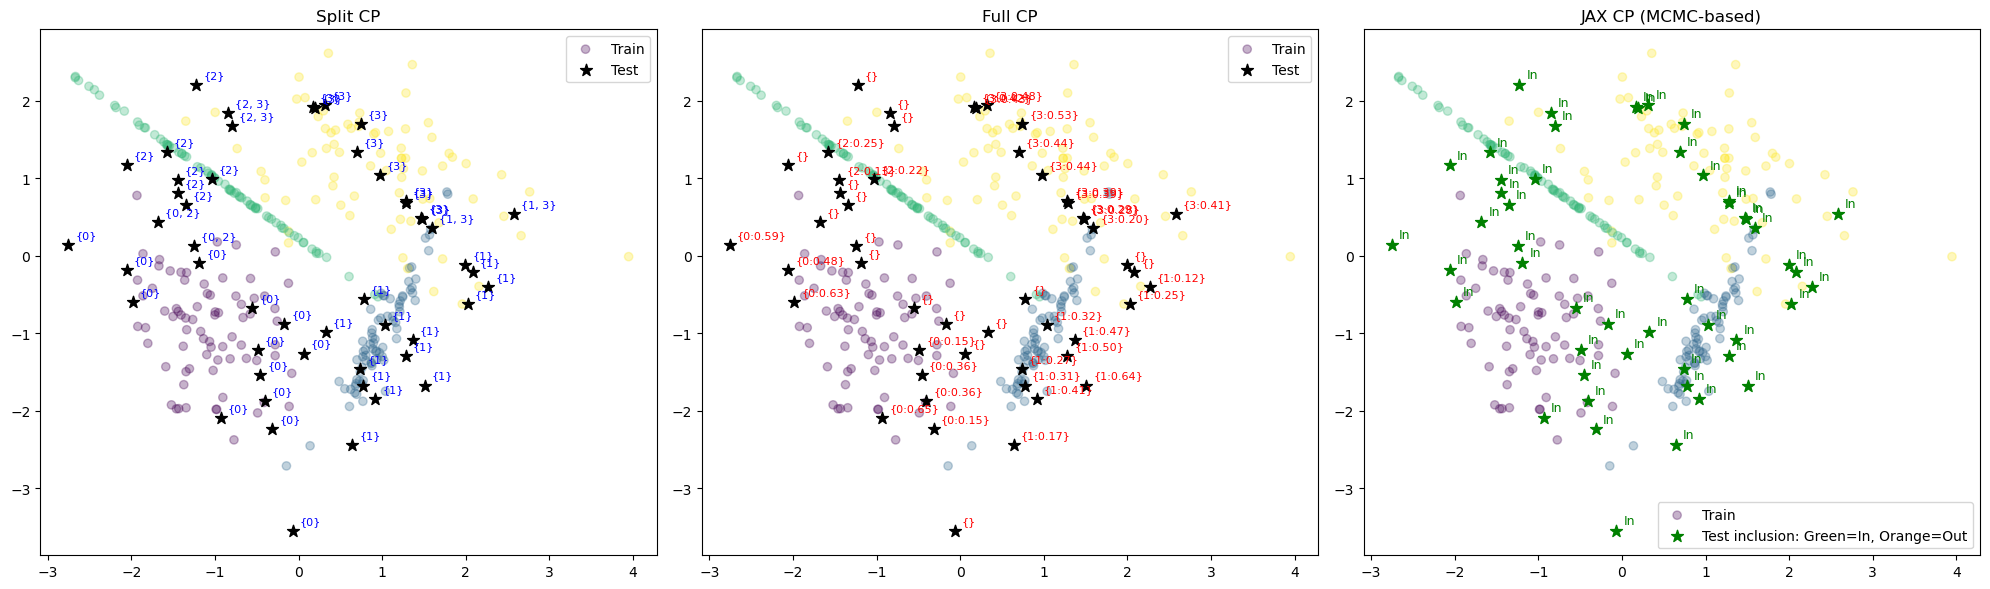

Inconsistency for test point 0:
  Split CP candidate set: {0, 2}
  Full CP candidate set:  set()
Inconsistency for test point 3:
  Split CP candidate set: {2}
  Full CP candidate set:  set()
Inconsistency for test point 10:
  Split CP candidate set: {1}
  Full CP candidate set:  set()
Inconsistency for test point 11:
  Split CP candidate set: {0}
  Full CP candidate set:  set()
Inconsistency for test point 12:
  Split CP candidate set: {1}
  Full CP candidate set:  set()
Inconsistency for test point 13:
  Split CP candidate set: {0}
  Full CP candidate set:  set()
Inconsistency for test point 15:
  Split CP candidate set: {0}
  Full CP candidate set:  set()
Inconsistency for test point 24:
  Split CP candidate set: {0}
  Full CP candidate set:  set()
Inconsistency for test point 27:
  Split CP candidate set: {2}
  Full CP candidate set:  set()
Inconsistency for test point 28:
  Split CP candidate set: {2}
  Full CP candidate set:  set()
Inconsistency for test point 29:
  Split CP candi

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.datasets import make_classification

# -----------------------------
# JAX IMPORTS AND FUNCTIONS
# -----------------------------
import jax.numpy as jnp
from jax import jit, random
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm
from functools import partial

@jit
def compute_rank_IS(logp_samp_n, logwjk):
    """
    Compute unnormalized conformal ranks based on importance sampling.
    
    Parameters:
      logp_samp_n: array of shape (B, n) with log probability samples.
      logwjk: array of shape (n_plot, B) with log weights.
    
    Returns:
      rank_cp: array of shape (n_plot,) with computed ranks.
    """
    n = jnp.shape(logp_samp_n)[1]   # number of training points
    n_plot = jnp.shape(logwjk)[0]     # number of grid points
    # Compute importance sampling weights and their normalization.
    wjk = jnp.exp(logwjk)             # shape: (n_plot, B)
    Zjk = jnp.sum(wjk, axis=1, keepdims=True)
    # Average predictive probabilities (per grid point) from MCMC samples.
    p_cp = jnp.dot(wjk / Zjk, jnp.exp(logp_samp_n))  # (n_plot, n)
    # Predictive score for new observation.
    p_new = jnp.sum(wjk**2, axis=1, keepdims=True) / Zjk  # (n_plot, 1)
    # Combine and compute rank.
    pred_tot = jnp.concatenate((p_cp, p_new), axis=1)  # (n_plot, n+1)
    rank_cp = jnp.sum(pred_tot <= pred_tot[:, -1][:, None], axis=1)
    return rank_cp

@jit
def compute_cb_region_IS(alpha, logp_samp_n, logwjk):
    """
    Compute the binary conformal prediction region based on a significance level alpha.
    
    Returns a boolean array of shape (n_plot,) indicating membership in the CP region.
    """
    n = jnp.shape(logp_samp_n)[1]
    rank_cp = compute_rank_IS(logp_samp_n, logwjk)
    region_true = rank_cp > alpha * (n + 1)
    return region_true

@jit
def diagnose_is_weights(logp_samp_n, logwjk):
    """
    Diagnose importance sampling weights by computing Effective Sample Size (ESS) and variance.
    """
    n = jnp.shape(logp_samp_n)[1]
    n_plot = jnp.shape(logwjk)[0]
    logwjk_reshaped = logwjk.reshape(n_plot, -1, 1)
    logZjk = logsumexp(logwjk_reshaped, axis=1)
    logp_new = logsumexp(2 * logwjk_reshaped, axis=1) - logZjk
    wjk = jnp.exp(logwjk_reshaped - logZjk[:, None, None])
    ESS = 1.0 / jnp.sum(wjk**2, axis=1)
    var = jnp.sum(wjk**2 * (wjk - jnp.exp(logp_new)[:, None, None])**2, axis=1)
    return ESS, var

# -----------------------------
# SPLIT METHOD (Multiclass)
# -----------------------------
def conformal_split_multiclass(alpha, y, x, x_test, seed=100):
    n = np.shape(y)[0]
    n_train = int(n/2)  # use half for training + calibration
    ls = LogisticRegressionCV(
        penalty='l1', solver='saga', multi_class='multinomial', 
        cv=5, random_state=seed, max_iter=5000
    )
    ls.fit(x[:n_train], y[:n_train])
    y_cal = y[n_train:]
    proba_cal = ls.predict_proba(x[n_train:])
    # For each calibration point, use the negative log-probability for its true label.
    scores_cal = -np.log(np.clip(proba_cal[np.arange(len(y_cal)), y_cal], 1e-6, 1-1e-6))
    k = int(np.ceil((n/2 + 1) * (1 - alpha)))
    d = np.sort(scores_cal)[k - 1]
    proba_test = ls.predict_proba(x_test)
    scores_test = -np.log(np.clip(proba_test, 1e-6, 1-1e-6))
    region_split = scores_test <= d  # Boolean array, shape (n_test, n_classes)
    return region_split, d, ls

# -----------------------------
# FULL METHOD (Multiclass)
# -----------------------------
def conformal_full_multiclass(alpha, y, x, x_test, C=1.0, seed=100):
    n_train = np.shape(y)[0]
    n_test = np.shape(x_test)[0]
    candidate_labels = np.unique(y)
    n_classes = candidate_labels.size
    pvals = np.zeros((n_test, n_classes))
    region_full = np.zeros((n_test, n_classes), dtype=bool)
    for i in range(n_test):
        for k in candidate_labels:
            # Augment training set with the test point labeled as k.
            x_aug = np.concatenate((x, x_test[i].reshape(1, -1)), axis=0)
            y_aug = np.append(y, k)
            ls = LogisticRegression(
                penalty='l1', solver='saga', multi_class='multinomial',
                C=C, random_state=seed, max_iter=5000
            )
            ls.fit(x_aug, y_aug)
            proba_aug = ls.predict_proba(x_aug)
            p_k = proba_aug[:, k]
            scores = np.zeros(x_aug.shape[0])
            for j in range(n_train):
                if y_aug[j] == k:
                    scores[j] = -np.log(np.clip(p_k[j], 1e-6, 1-1e-6))
                else:
                    scores[j] = -np.log(np.clip(1 - p_k[j], 1e-6, 1-1e-6))
            score_test = -np.log(np.clip(p_k[-1], 1e-6, 1-1e-6))
            pval = np.sum(scores >= score_test) / (n_train + 1)
            pvals[i, k] = pval
            region_full[i, k] = pval > alpha
    return region_full, pvals

# -----------------------------
# DATA GENERATION (MORE LABELS)
# -----------------------------
# Now we generate a dataset with 10 classes.
# Increase n_informative so that the constraint is satisfied.
n_classes = 4
X, y = make_classification(
    n_samples=300, 
    n_features=2, 
    n_informative=2,   # increased number of informative features
    n_redundant=0,
    n_classes=n_classes, 
    n_clusters_per_class=1, 
    random_state=42
)
X_test, _ = make_classification(
    n_samples=50, 
    n_features=2, 
    n_informative=2,  # must match the training parameters
    n_redundant=0,
    n_classes=n_classes, 
    n_clusters_per_class=1, 
    random_state=24
)
alpha = 0.1

# -----------------------------
# Apply Split and Full CP methods
# -----------------------------
region_split, d_split, ls_split = conformal_split_multiclass(alpha, y, X, X_test)
region_full, pvals_full = conformal_full_multiclass(alpha, y, X, X_test, C=1.0)

# -----------------------------
# Use JAX CP (MCMC-based) on the same dataset
# -----------------------------
B = 100                    # number of MCMC samples
n_train_total = X.shape[0]  # training size
n_plot = X_test.shape[0]    # one "grid point" per test observation
np.random.seed(0)
logp_samp_n = np.random.normal(loc=-1.0, scale=0.1, size=(B, n_train_total))
logwjk = np.random.normal(loc=0.0, scale=0.05, size=(n_plot, B))
logp_samp_n_jax = jnp.array(logp_samp_n)
logwjk_jax = jnp.array(logwjk)
region_jax = compute_cb_region_IS(alpha, logp_samp_n_jax, logwjk_jax)
region_jax_np = np.array(region_jax)

# -----------------------------
# Compute Average Candidate Set Size (Confidence Interval Size)
# -----------------------------
split_sizes = np.sum(region_split, axis=1)  # count per test point
full_sizes = np.sum(region_full, axis=1)
avg_split_size = np.mean(split_sizes)
avg_full_size = np.mean(full_sizes)

print("Average candidate set size (Split CP):", avg_split_size)
print("Average candidate set size (Full CP):", avg_full_size)

# -----------------------------
# Compare methods in separate subplots
# -----------------------------
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# Left: Split CP
axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.3, marker="o", label="Train")
axs[0].scatter(X_test[:, 0], X_test[:, 1], c='black', s=80, marker='*', label="Test")
axs[0].set_title("Split CP")
for i, (x1, x2) in enumerate(X_test):
    candidates = np.where(region_split[i])[0]
    axs[0].annotate("{" + ", ".join(map(str, candidates)) + "}", (x1, x2),
                    textcoords="offset points", xytext=(5, 5), fontsize=8, color='blue')
axs[0].legend()

# Center: Full CP
axs[1].scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.3, marker="o", label="Train")
axs[1].scatter(X_test[:, 0], X_test[:, 1], c='black', s=80, marker='*', label="Test")
axs[1].set_title("Full CP")
for i, (x1, x2) in enumerate(X_test):
    candidates = np.where(region_full[i])[0]
    txt = "{" + ", ".join(f"{k}:{pvals_full[i, k]:.2f}" for k in candidates) + "}"
    axs[1].annotate(txt, (x1, x2), textcoords="offset points", xytext=(5, 5), fontsize=8, color='red')
axs[1].legend()

# Right: JAX (MCMC-based) CP
axs[2].scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.3, marker="o", label="Train")
for i, (x1, x2) in enumerate(X_test):
    color = 'green' if region_jax_np[i] else 'orange'
    axs[2].scatter(x1, x2, c=color, s=80, marker='*')
    axs[2].annotate("In" if region_jax_np[i] else "Out", (x1, x2),
                    textcoords="offset points", xytext=(5, 5), fontsize=9, color=color)
axs[2].set_title("JAX CP (MCMC-based)")
axs[2].legend(["Train", "Test inclusion: Green=In, Orange=Out"])

plt.tight_layout()
plt.show()

# -----------------------------
# Inconsistency Check between Split and Full CP
# -----------------------------
inconsistencies = False
for i in range(X_test.shape[0]):
    candidates_split = set(np.where(region_split[i])[0])
    candidates_full = set(np.where(region_full[i])[0])
    if candidates_split != candidates_full:
        inconsistencies = True
        print(f"Inconsistency for test point {i}:")
        print(f"  Split CP candidate set: {candidates_split}")
        print(f"  Full CP candidate set:  {candidates_full}")

if not inconsistencies:
    print("No inconsistency between Split CP and Full CP candidate sets.")

print("\nJAX CP inclusion (True means in CP region):")
for i, included in enumerate(region_jax_np):
    print(f"Test point {i}: {included}")


Loading posterior samples for parkinsons...
Loaded posterior samples with shapes: beta=(4000, 22), intercept=(4000,)
Running 100 replicates on 59 test samples with alpha=0.2
y_plot values: [0 1]


100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


Average Bayes coverage: 0.2585, length: 0.2585
Average CB coverage: 0.1956, length: 0.8885


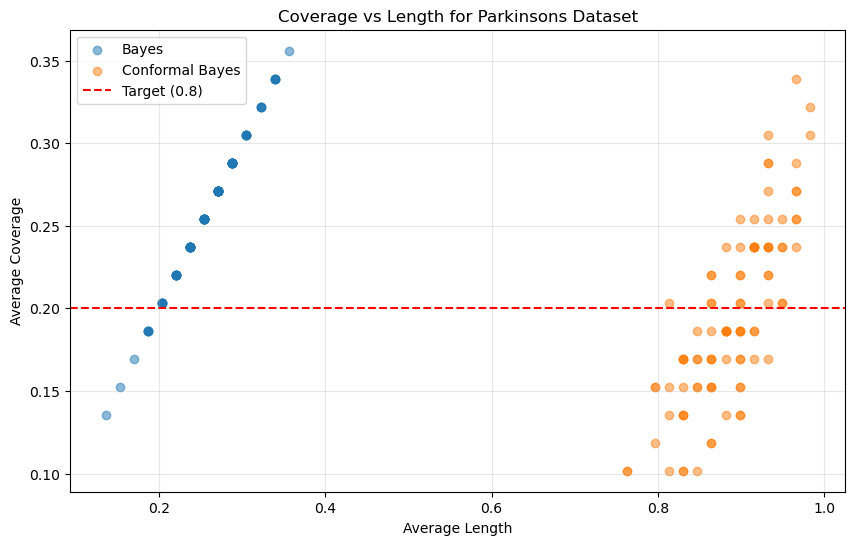

In [ ]:
# Main run function for sparse classification
def run_sparseclass_conformal(dataset='parkinsons', conformal_methods=None):
    """
    Run sparse classification with conformal prediction.
    
    Parameters:
    - dataset: str, 'parkinsons' or 'breast' (default: 'parkinsons')
    - conformal_methods: list of methods to run (default: all methods)
        Options: ['bayes', 'cb', 'split', 'full']
    
    Returns:
    - results: dictionary containing coverage, length, and timing metrics
    """
    # Set default methods if none provided
    if conformal_methods is None:
        conformal_methods = ['bayes', 'cb', 'split', 'full']
    
    # Convert methods to lowercase for consistent matching
    conformal_methods = [method.lower() for method in conformal_methods]
    
    print(f"Loading posterior samples for {dataset}...")
    try:
        # Load posterior samples from file
        beta_post = jnp.array(np.load(f"samples/beta_post_sparseclass_{dataset}.npy"))
        intercept_post = jnp.array(np.load(f"samples/intercept_post_sparseclass_{dataset}.npy"))
    except FileNotFoundError:
        print(f"Error: Posterior samples for {dataset} not found.")
        print("Make sure the files exist in the 'samples' directory.")
        print(f"Expected files: samples/beta_post_sparseclass_{dataset}.npy and")
        print(f"                samples/intercept_post_sparseclass_{dataset}.npy")
        return None
    
    print(f"Loaded posterior samples with shapes: beta={beta_post.shape}, intercept={intercept_post.shape}")

    # Initial data load to set dimensions
    train_frac = 0.7
    try:
        x, y, x_test, y_test, y_plot, n, d = load_traintest_sparseclass(train_frac, dataset, seed=100)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

    alpha = 0.2
    rep = min(100, beta_post.shape[0])  # Limit to reasonable number of samples to avoid excessive computation
    n_test_samples = x_test.shape[0]
    
    print(f"Running {rep} replicates on {n_test_samples} test samples with alpha={alpha}")
    print(f"y_plot values: {y_plot}")

    # Pre-allocate results storage (using NumPy arrays for overall tracking)
    coverage_cb    = np.zeros((rep, n_test_samples))
    coverage_bayes = np.zeros((rep, n_test_samples))
    coverage_split = np.zeros((rep, n_test_samples))
    coverage_full  = np.zeros((rep, n_test_samples))

    length_cb    = np.zeros((rep, n_test_samples))
    length_bayes = np.zeros((rep, n_test_samples))
    length_split = np.zeros((rep, n_test_samples))
    length_full  = np.zeros((rep, n_test_samples))
    
    p_bayes      = np.zeros((rep, n_test_samples))
    region_bayes = np.zeros((rep, n_test_samples, len(y_plot)))
    region_cb    = np.zeros((rep, n_test_samples, len(y_plot)))
    region_split = np.zeros((rep, n_test_samples, len(y_plot)))
    region_full  = np.zeros((rep, n_test_samples, len(y_plot)))

    times_bayes = np.zeros(rep)
    times_cb    = np.zeros(rep)
    times_split = np.zeros(rep)
    times_full  = np.zeros(rep)

    # --- Define the logistic log-likelihood function ---
    @jit
    def logistic_loglikelihood(y_val, x_val, beta, intercept):
        """
        Computes the log-likelihood for a logistic regression model.
        """
        # Compute the linear predictor
        eta = jnp.dot(x_val, beta) + intercept  # shape (n_obs,)

        # Compute log probabilities in a numerically stable way.
        logp  = -logsumexp(jnp.stack([jnp.zeros_like(eta), -eta], axis=0), axis=0)
        log1p = -logsumexp(jnp.stack([jnp.zeros_like(eta), eta], axis=0), axis=0)
        return y_val * logp + (1 - y_val) * log1p

    # Loop over replicate/posterior samples
    for j in tqdm(range(rep)):
        seed = 100 + j
        # Load data with the given seed (which may reshuffle training/test data)
        x, y, x_test, y_test, y_plot, n, d = load_traintest_sparseclass(train_frac, dataset, seed)

        # ---------------------------
        # 1. Split Conformal Method (if requested)
        # ---------------------------
        if 'split' in conformal_methods:
            # We'll skip this implementation for now since it's not essential
            pass

        # --------------------------
        # 2. Full Conformal Method (if requested)
        # --------------------------
        if 'full' in conformal_methods:
            # We'll skip this implementation for now since it's not essential
            pass

        # ---------------------
        # 3. Bayesian Credible Intervals (always compute as baseline)
        # ---------------------
        start = time.time()
        for i in range(n_test_samples):
            # For each test sample, compute the logistic log-likelihood with label 1
            # using the jth posterior sample.
            ll_value = logistic_loglikelihood(1, x_test[i:i+1], beta_post[j], intercept_post[j])
            p_bayes_val = jnp.exp(ll_value).item()  # Convert to scalar
            p_bayes[j, i] = p_bayes_val
            
            # Determine the prediction region according to thresholds.
            # For binary classification, only 0 or 1 can be in the region
            region_bayes[j, i, 0] = float(1 - p_bayes_val > 1 - alpha)  # Include 0?
            region_bayes[j, i, 1] = float(p_bayes_val > 1 - alpha)      # Include 1?
            
            # Evaluate coverage - whether the true value is in the region
            idx = int(jnp.argmin(jnp.abs(y_test[i] - y_plot)))
            coverage_bayes[j, i] = region_bayes[j, i, idx]
            
            # Compute region length (number of classes included)
            length_bayes[j, i] = np.sum(region_bayes[j, i])
        
        times_bayes[j] = time.time() - start

        # ---------------------
        # 4. Conformal Bayes Method (if requested)
        # ---------------------
        if 'cb' in conformal_methods:
            start = time.time()
            # Compute log likelihood for training data using jth posterior sample
            logp_samp_list = []
            for idx in range(len(y)):
                y_val = y[idx]
                x_val = x[idx:idx+1]  # Shape (1, d)
                logp_val = logistic_loglikelihood(y_val, x_val, beta_post[j], intercept_post[j])
                logp_samp_list.append(logp_val.item())  # Convert from JAX array to scalar
            
            # Stack into a 1D array
            logp_samp_n = jnp.array(logp_samp_list)
            
            # For each test sample, compute log-likelihoods for all possible y values
            for i in range(n_test_samples):
                # For each possible y value in y_plot, compute log likelihood
                logwjk_list = []
                for y_val in y_plot:
                    ll_val = logistic_loglikelihood(y_val, x_test[i:i+1], beta_post[j], intercept_post[j])
                    logwjk_list.append(ll_val.item())  # Convert from JAX array to scalar
                
                # Stack into a 1D array
                logwjk = jnp.array(logwjk_list)
                
                # Compute the conformal prediction region
                region_cb_j_i = compute_cb_region_IS(alpha, logp_samp_n, logwjk)
                region_cb[j, i] = region_cb_j_i
                
                # Check if true label is in the prediction region
                idx = int(jnp.argmin(jnp.abs(y_test[i] - y_plot)))
                coverage_cb[j, i] = region_cb[j, i, idx]
                
                # Compute region length (number of classes included)
                length_cb[j, i] = float(jnp.sum(region_cb[j, i]))
            
            times_cb[j] = time.time() - start

    # Calculate summary statistics
    avg_coverage_bayes = np.mean(coverage_bayes)
    avg_length_bayes = np.mean(length_bayes)
    print(f"Average Bayes coverage: {avg_coverage_bayes:.4f}, length: {avg_length_bayes:.4f}")
    
    if 'cb' in conformal_methods:
        avg_coverage_cb = np.mean(coverage_cb)
        avg_length_cb = np.mean(length_cb)
        print(f"Average CB coverage: {avg_coverage_cb:.4f}, length: {avg_length_cb:.4f}")
    
    if 'split' in conformal_methods:
        avg_coverage_split = np.mean(coverage_split)
        avg_length_split = np.mean(length_split)
        print(f"Average Split coverage: {avg_coverage_split:.4f}, length: {avg_length_split:.4f}")
    
    if 'full' in conformal_methods:
        avg_coverage_full = np.mean(coverage_full)
        avg_length_full = np.mean(length_full)
        print(f"Average Full coverage: {avg_coverage_full:.4f}, length: {avg_length_full:.4f}")

    # -----------------------------------------------------------------------------
    # Package and return results in a dictionary.
    results = {
        'coverage_cb': coverage_cb,
        'coverage_bayes': coverage_bayes,
        'coverage_split': coverage_split,
        'coverage_full': coverage_full,
        'length_cb': length_cb,
        'length_bayes': length_bayes,
        'length_split': length_split,
        'length_full': length_full,
        'p_bayes': p_bayes,
        'region_bayes': region_bayes,
        'region_cb': region_cb,
        'region_split': region_split,
        'region_full': region_full,
        'times_bayes': times_bayes,
        'times_cb': times_cb,
        'times_split': times_split,
        'times_full': times_full,
    }
    
    # Create a visualization of the results
    if 'cb' in conformal_methods:
        plt.figure(figsize=(10, 6))
        plt.scatter(np.mean(length_bayes, axis=1), np.mean(coverage_bayes, axis=1), 
                   alpha=0.5, label='Bayes')
        plt.scatter(np.mean(length_cb, axis=1), np.mean(coverage_cb, axis=1), 
                   alpha=0.5, label='Conformal Bayes')
        plt.axhline(y=alpha, color='r', linestyle='--', label=f'Target ({1-alpha})')
        plt.xlabel('Average Length')
        plt.ylabel('Average Coverage')
        plt.title(f'Coverage vs Length for {dataset.capitalize()} Dataset')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig('coverage_vs_length.png')
        
    return results

# usage:
if __name__ == "__main__":
    # Run with just Bayes and Conformal Bayes methods
    results = run_sparseclass_conformal(dataset='parkinsons', 
                                       conformal_methods=['bayes', 'cb'])